In [205]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn import set_config
from sklearn.metrics import mean_squared_error
set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
file = r'/home/alcatto/code/Al-Catto/project_sandbox/raw_data/WSC-variable_cross-check_v1.xlsx'
data = r'/home/alcatto/code/Al-Catto/project_sandbox/raw_data/wsc-dataset-0.2.0.csv'

In [3]:
df = pd.read_excel(file)
data_df = pd.read_csv(data)

In [4]:
data_df['nasal_cong_none'].fillna(0, inplace=True)

In [5]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]

In [6]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [7]:
data_df.isnull().sum().sort_values(ascending=False)/len(data_df)

psg_oxygen         0.997665
psg_cpap           0.935019
cigars_day         0.919844
bowls_day          0.917899
thyroid_problem    0.867704
                     ...   
nasal_cong_none    0.000000
awake_freq         0.000000
apnea_freq         0.000000
choke_freq         0.000000
waso               0.000000
Length: 134, dtype: float64

In [8]:
balance_cutoff = 0.9
imbalanced_classes = []
for col in data_df.columns:
    _ = data_df.columns.get_loc(col)
    if data_df.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
        imbalanced_classes.append((col, data_df.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

In [9]:
imbalanced_classes

[('race', array([0.95836576])),
 ('coronary_ynd', array([0.9233463])),
 ('angina_ynd', array([0.96730245])),
 ('atheroscl_ynd', array([0.9758661])),
 ('heartattack_ynd', array([0.95679253])),
 ('congestivehf_ynd', array([0.98871595])),
 ('coronarybypass_ynd', array([0.95525292])),
 ('stroke_ynd', array([0.97743191])),
 ('emphysema_ynd', array([0.97898833])),
 ('angioplasty_ynd', array([0.95758755])),
 ('pacemaker_ynd', array([0.99105058])),
 ('coronary_artery_stent_ynd', array([0.9766537])),
 ('asthma_med', array([0.92140078])),
 ('asthma_rescue_med', array([0.96031128])),
 ('asthma_control_med', array([0.93696498])),
 ('dep_maoi_med', array([0.99922179])),
 ('dep_tca_med', array([0.9766537])),
 ('htn_alpha_med', array([0.96264591])),
 ('htn_arb_med', array([0.93190661])),
 ('narcotics_med', array([0.9766537])),
 ('decongestants_med', array([0.95914397])),
 ('anxiety_med', array([0.92801556])),
 ('estrogen_med', array([0.93385214])),
 ('androgen_med', array([0.99688716])),
 ('progester

In [10]:
len(imbalanced_classes)

29

In [11]:
imbalanced_list = []
for classes in imbalanced_classes:
    imbalanced_list.append(classes[0])

In [12]:
data_df.drop(imbalanced_list, axis=1, inplace=True)
data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)

In [13]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [14]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [15]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df1 = pd.concat(frames, axis = 1, verify_integrity=True)

##drop original row names

data_df1.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

In [16]:
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,78.0,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,87.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,84.6,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
#y = data_df1.se
#X = data_df1.drop('se', axis=1)

In [18]:
# X

## exploration of TSO target

(array([610., 343., 116.,  22.,  18.,   2.,   4.,   0.,   3.,   2.]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.]),
 <BarContainer object of 10 artists>)

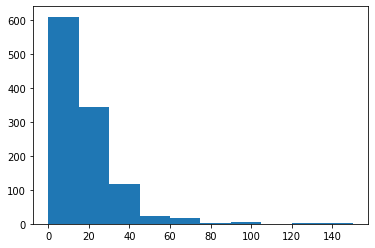

In [19]:
plt.hist(data_df1['tso'])

## 

## sorting categoricals & targets

In [20]:
targets = ['tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds', 'waso', 'se', 'sleepiness'
          ]

In [21]:
numerics = ['creatinine', 'glucose', 'hdl', 'ldl','total_cholesterol', 'triglycerides', 'uric_acid', 'weightkg', 'bmi',
       'headcm', 'waist_girth1', 'waist_girth2', 'hip_girth1', 'hip_girth2',
       'neck_girth1', 'neck_girth2', 'sit_sys1', 'sit_dia1', 'sit_sys2',
       'sit_dia2', 'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam', 'zung_score', 'zung_index', 'state',
       'trait', 'beer_week', 'wine_week', 'hard_week', 'bowls_day', 'packs_week', 'cigars_day',
       'smoke_years', 'pack_years','workday', 'weekend',
       'naps', 'snore_freq',
       'num_pregnancies', 'ahi',
       'minsao2tst', 'ptstl90', 'age', 'heightcm', 'cans_cola', 'cups_coffee',
       'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq', 'ho_score'
           ]

In [22]:
categoricals = data_df1.drop(columns = numerics)
#categoricals = data_df1.drop(columns = targets)

In [23]:
ordinals = ['menopausal_status']

In [24]:
high_val_features = ['age',
 'weightkg',
 'bmi',
 'neck_girth1',
 'sit_sys1',
 'sit_dia1',
 'zung_score',
 'zung_index',
 'state',
 'trait',
 'caffeine',
 'hard_week',
 'alcohol_wk',
 'bowls_day',
 'packs_week',
 'cigars_day',
 'smoke_years',
 'pack_years',
 'eval_general',
 'eval_life',
 'eval_health',
 'workday',
 'weekend',
 'snore_freq',
 'snore_vol',
 'choke_freq',
 'apnea_freq']

In [25]:
#cross check high_val_features
data_df1[high_val_features]

,age,weightkg,bmi,neck_girth1,sit_sys1,sit_dia1,zung_score,zung_index,state,trait,...,pack_years,eval_general,eval_life,eval_health,workday,weekend,snore_freq,snore_vol,choke_freq,apnea_freq
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,52,85.5,27.6,39.5,112.0,78.0,24.0,30.00,20.0,24.0,...,0.000000,1,1,1,7.5,8.0,2.0,1,1,1
10191,50,73.0,25.3,31.5,132.0,84.0,31.0,38.75,27.4,24.0,...,0.000000,1,2,2,6.5,10.5,1.0,1,1,1
10198,57,115.5,46.9,39.5,142.0,88.0,30.0,37.50,25.3,28.0,...,47.142857,1,1,3,6.5,9.0,9.0,9,1,1
10226,55,79.2,26.5,39.5,128.0,76.0,34.0,42.50,37.9,36.0,...,78.000000,1,3,3,7.0,9.0,5.0,4,2,9
10241,51,100.6,34.4,42.0,140.0,88.0,31.0,38.75,21.1,25.0,...,1.142857,2,1,5,5.5,6.5,4.0,2,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,60,84.0,25.6,40.0,118.0,77.0,22.0,27.50,20.0,21.0,...,0.000000,1,1,2,6.0,8.0,2.0,2,1,1
99651,69,102.5,35.1,46.0,154.0,106.0,28.0,35.00,20.0,22.0,...,2.857143,1,1,2,7.0,7.0,5.0,4,9,9
99761,71,94.0,40.7,35.5,160.0,88.0,33.0,41.25,32.6,30.0,...,0.000000,1,1,2,7.5,9.0,5.0,3,9,9


## ac - TSO Linear Regression w/ Pipe

In [64]:
data_df1 = data_df1.fillna(0)

In [65]:
y = data_df1.tso
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [66]:
#X = data_df1[['snore_vol', 'choke_freq', 'apnea_freq', 'awake_freq']]

In [67]:
#X['target'] = y

In [68]:
#X.corr()

In [69]:
y.isna().sum().sum()

0

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [71]:
scaler = RobustScaler()

In [72]:
linreg = LinearRegression()

In [73]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [74]:
tso_lin_Reg = pipe.fit(X_train, y_train)

In [75]:
pipe.score(X_test, y_test,)

-3.3048764264477786

### Baseline with mean - using dummy regressor

In [264]:
data_df1 = data_df1[data_df1.tso < 80]
y = data_df1.tso
#X = data_df1.drop(targets, axis=1)
#X = data_df1.drop(categoricals, axis=1)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [266]:
y_pred = y_train.mean()

In [267]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

In [268]:
dummyr = DummyRegressor(strategy='mean')

In [269]:
dummyr.fit(X_train, y_train)

DummyRegressor()

In [270]:
# Baseline to beat
y_pred = dummyr.predict(X_test)

In [271]:
y_pred.shape

(279,)

In [272]:
mae_baseline = mean_absolute_error(y_test, y_pred)
mae_baseline

8.189105659648446

### Linear model with entire data set

In [297]:
data_df1 = data_df1[data_df1.tso < 80]

In [298]:
data_df1 = data_df1.fillna(0)

In [299]:
#data_df1['tso']

In [300]:
y = data_df1.tso
X = data_df1['waistgirthm','waist_girth2' ]
#X = data_df1.drop('tso', axis=1)
#X = data_df1.drop(targets, axis=1)
#X = data_df1.drop(categoricals, axis=1)

KeyError: ('waistgirthm', 'waist_girth2')

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [302]:
scaler = MinMaxScaler()

In [303]:
linreg = LinearRegression()

In [304]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [305]:
 pipe.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[134.  116.  122.3 111.3  92.   95.5 109.  112.   92.   77.   93.5  78.8
 112.  117.5 141.  112.  115.5 104.   87.   95.3  74.8  91.8  84.8 108.
 138.   94.   87.3  94.8  91.   74.   95.  104.3 130.  139.5  95.3  97.
 115.   98.   85.   78.  119.   91.8 103.5 142.  104.   87.   73.  120.
 101.  114.  104.5 116.3  69.   90.  106.  112.  114.5 122.5 117.  100.3
 102.3  99.3  83.8  82.5  92.3 126.3 114.   95.   93.5  99.  110.  103.5
  96.8  98.   94.3  79.   88.   97.5  86.   79.8  77.   95.3  94.   93.5
  90.  117.  109.3 110.3 102.5 126.   98.5  76.  117.5 108.  109.  126.5
  82.3 105.8  96.5  81.8  86.  112.  117.  112.5  97.  117.3  99.  103.
  87.3  90.8  89.3 114.   76.   89.3  83.   94.   72.5  83.  107.   85.5
  92.  101.5  82.  112.   88.   65.  114.  106.  112.  105.5 109.3 100.5
  96.5 100.   77.   83.5 153.  107.  105.5  86.8  99.8  58.   80.  111.
 113.8  89.   89.  104.  113.3  82.  133.8 101.3  90.8  80.  101.5 100.5
  94.5 106.   86.  105.5 102.  100.3 109.3  89.5  88.3  83.8  85.   87.
  75.8  85.   90.   96.  119.8 113.3  58.   96.   70.3 102.8  90.8 101.3
 142.  102.  122.3  69.5  99.   94.   88.5 104.5 115.   93.  103.  105.
  99.   89.   87.5  94.   89.3  83.   92.   80.  108.3  71.   84.   96.
  96.  103.  115.5 125.  102.   79.5 100.   87.  101.  114.3 124.3  94.8
 130.   90.3  89.5  87.5  86.   95.8  71.  121.5  72.  116.   95.  101.
 111.  106.  126.  100.  111.5 101.5 113.8  94.5  68.3  89.  111.  100.
  82.8  88.  141.   88.8  86.3  83.3 128.5 105.3  95.  119.3 109.  126.
 120.  105.   94.5 104.5  98.  142.8 109.  107.8  77.5 124.   96.  122.
 111.5  83.  107.   76.5  97.3  85.8 160.   97.5 118.8  93.8 107.5  79.
  94.8  90.8  74.  106.8 101.8 146.  131.8  90.  120.   74.5 104.  108.3
 108.  108.   73.5  86.3 104.  101.5 113.   90.3  91.5 117.3  70.3 107.3
  92.  108.   92.3 108.   83.8 128.  105.  124.5 100.  127.   95.  118.
  98.   87.   90.5 107.3 115.   93.  107.   86.5 102.   89.  121.   89.
  96.   99.8 123.   90.   93.8  86.3 111.  104.   97.5  82.   75.5  91.3
  95.5 123.  103.8  88.  143.   93.  128.   90.8 121.8 115.   97.  119.
  82.8 118.   91.  102.8 100.3  93.8 107.8  92.  120.5 116.  106.8 112.8
  63.  112.8 113.   94.5 121.   95.3  89.3 125.5 133.  100.  127.  119.
  79.  144.  109.5 104.5 104.   79.  102.5  86.   74.8  73.   98.5  78.5
 115.8 103.   98.   87.   97.3 157.   87.  126.   84.8  96.8  85.  103.3
  96.  107.3 107.   91.8 116.  125.   91.5  96.   75.5 125.   90.3  95.8
  87.8  95.3 155.  100.   98.   93.  112.5  95.5  78.5 112.5  69.3  76.
 111.   98.  101.   84.3 112.3 133.5  96.8 102.  115.5  94.5  94.   96.
 110.8 113.8 112.  107.5 103.   89.   91.   83.5  85.  101.5 101.5  86.5
 132.  112.   81.5  82.  114.  117.5 109.  100.5  67.  119.5 122.   85.3
 104.   94.3 123.3 133.  134.  139.3  90.5 131.  109.  107.  126.8  80.
 126.5 129.5 111.8  79.8  94.   98.8 116.5  76.  108.5 112.  117.  119.3
  85.3  77.5  83.  104.   97.   80.8  80.5 101.   98.  111.3 141.   99.
  81.  107.3 123.   71.  115.3 109.5 107.5  97.3  87.   79.  133.  130.3
  92.3  95.   97.  110.3 101.3  98.   81.   93.3  98.  112.3  89.   87.
 106.   88.3 114.   96.   88.   90.3  95.5  78.3 110.8  87.  105.  114.3
  99.   95.5  87.  155.  103.   69.5 120.5  79.  132.   85.5  96.   86.5
 133.   75.5 100.8  87.   88.5 100.  107.  106.   94.   66.   69.  108.
  95.3 108.   93.  148.3  84.  101.8  98.5  89.  104.   90.5 105.3  94.5
 112.3  94.   91.  121.   93.8  76.3  89.  101.   97.8 114.3  94.5 108.5
  95.  117.  108.3 101.5 112.3 115.   72.  122.5 142.  100.5 109.3  96.
 105.  112.   91.5 105.  108.   83.   88.  110.  120.8  96.8 122.  100.3
 107.3 113.  114.8  79.   77.3  86.   83.   96.  104.   98.   96.   96.
 128.5  86.5 103.   92.  105.   97.3 137.  102.   89.8  80.8  95.   77.
 109.   90.   93.3  81.  110.  103.   87.3 102.8 104.5 109.8 138.8 119.
 125.5 110.  112.   85.5 126.5  90.   90.3 109.   86.   92.   93.  102.
 112.5 108.5 130.   74.   83.8 110.8  90.  113.  121.   92.3 104.   90.3
  83.3 111.  106.   90.8  88.  107.5 135.5  87.   81.3 133.8  78.8  74.
 100.3  76.3 118.3  96.3 113.   95.  128.  127.  111.8  87.  108.5 135.8
  92.  112.   82.8 102.8  93.5 116.   92.  106.  110.8 104.5 121.   87.
 113.3 105.3 117.8  85.   81.   92.8  91.  127.3  94.8  99.5 109.5  93.
  98.  115.8  80.   92.   83.  116.5 143.   95.5 107.   80.8  84.   98.5
  86.  120.5  88.5  92.5  97.3  90.  114.   91.   87.3  99.5  88.   82.
  79.3 109.5 101.   86.3 110.8  78.   95.5 118.5 124.5 115.5  94.3 108.5
 117.  100.  106.5 105.8 106.3  91.  126.   71.   74.   81.   79.3  79.5
 114.   96.8 100.   81.5  74.  108.   93.5  95.  102.   87.  107.8 130.
  89.   85.  125.5  96.3 118.8 131.5  94.  135.3 101.  135.  108.   91.
  99.  121.   99.5 123.3 107.3 107.   97.  109.   99.   65.8 103.8  78.
  93.8  90.   78.   82.   86.   70.   92.   84.5  78.5  97.3  90.   93.
  84.  110.5 128.  112.  129.3  75.5 111.   87.  112.8 102.   91.3  84.8
 117.3  87.   72.  108.  123.3 104.  103.  105.   89.   96.5  94.5  94.
 120.3 104.   99.  103.5  96.5  85.5 137.3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [306]:
y_pred_lin = pipe.predict(X_test)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [307]:
mae_baseline = mean_absolute_error(y_test, y_pred_lin)
mae_baseline

8.41569248725072

### Feature permutation

In [109]:
from sklearn.inspection import permutation_importance

lin_model = LinearRegression().fit(X_train, y_train)

In [110]:
per_score = permutation_importance(lin_model,X_train, y_train, n_repeats=10)

In [130]:
type(per_score.importances)
per_score.importances_mean.shape

(60,)

In [129]:
importance_df = pd.DataFrame(np.vstack((X_train.columns, per_score.importances_mean)).T)

In [131]:
importance_df.columns=['feature','score decrease']

In [166]:
importance_df.sort_values(by='score decrease', ascending=False).head()

,feature,score decrease
24,waistgirthm,157.573212
13,waist_girth2,64.864476
22,hipgirthm,39.17611
12,waist_girth1,11.970586
15,hip_girth2,9.883946


### Linear Model with reduced X

In [143]:
y = data_df1.tso
X = data_df1[['waistgirthm','waist_girth2']]

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [145]:
scaler = RobustScaler()

In [146]:
linreg = LinearRegression()

In [147]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [148]:
 pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('linereg', LinearRegression())])

In [149]:
pipe.score(X_test, y_test)

-2.484422778616038

### Ridge model

In [159]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [160]:
y = data_df1.tso
X = data_df1.drop('tso', axis=1)
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [162]:
linreg = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=0.2).fit(X_train, y_train)
lasso = Lasso(alpha=0.2).fit(X_train, y_train)



In [163]:
coefs = pd.DataFrame({
    "coef_linreg": pd.Series(linreg.coef_, index = X.columns),
    "coef_ridge": pd.Series(ridge.coef_, index = X.columns),
    "coef_lasso": pd.Series(lasso.coef_, index= X.columns)})\



In [164]:
coefs\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: black')

,coef_linreg,coef_ridge,coef_lasso
age,0,0,0
creatinine,2,2,0
glucose,0,0,0
hdl,0,0,0
ldl,0,0,0
total_cholesterol,0,0,0
triglycerides,0,0,0
uric_acid,0,0,0
heightcm,0,0,0
weightkg,0,0,0


## ac - TSO Linear Regression w/o Pipe

In [35]:
y = data_df1.tso
X = data_df1[high_val_features]


In [36]:
X.columns

Index(['age', 'weightkg', 'bmi', 'neck_girth1', 'sit_sys1', 'sit_dia1',
       'zung_score', 'zung_index', 'state', 'trait', 'caffeine', 'hard_week',
       'alcohol_wk', 'bowls_day', 'packs_week', 'cigars_day', 'smoke_years',
       'pack_years', 'eval_general', 'eval_life', 'eval_health', 'workday',
       'weekend', 'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq'],
      dtype='object')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [38]:
y_train.mean()

15.623515439429928

In [39]:
#X_train.select_dtypes(include=['float64', 'int64'])


In [40]:
X_train.columns

Index(['age', 'weightkg', 'bmi', 'neck_girth1', 'sit_sys1', 'sit_dia1',
       'zung_score', 'zung_index', 'state', 'trait', 'caffeine', 'hard_week',
       'alcohol_wk', 'bowls_day', 'packs_week', 'cigars_day', 'smoke_years',
       'pack_years', 'eval_general', 'eval_life', 'eval_health', 'workday',
       'weekend', 'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq'],
      dtype='object')

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,age,weightkg,bmi,neck_girth1,sit_sys1,sit_dia1,zung_score,zung_index,state,trait,...,pack_years,eval_general,eval_life,eval_health,workday,weekend,snore_freq,snore_vol,choke_freq,apnea_freq
0,-0.530477,-0.407288,0.162589,-1.153137,-0.953750,0.179758,-1.167563,-1.167563,-0.912022,-1.066675,...,-0.510135,-0.646451,-1.479021,-1.577682,-0.966179,0.243632,-0.811809,-1.000153,-0.474293,-0.704626
1,-0.652649,-0.770514,-0.459621,-0.917957,0.614015,1.765678,-0.162801,-0.162801,0.907382,0.178510,...,-0.510135,0.674694,-0.057405,0.807252,-0.022209,-0.597684,2.267215,1.706569,1.625993,-0.704626
2,1.179934,2.319261,1.393182,1.669025,1.940585,0.972718,0.554886,0.554886,-0.657840,-0.613881,...,0.592172,-0.646451,-0.057405,-0.385215,0.921761,0.243632,-0.371949,1.706569,-0.774333,-0.704626
3,-0.286132,0.078585,-0.349006,0.610714,0.614015,-0.613202,2.707948,2.707948,0.679957,1.989688,...,1.458270,1.995840,-0.057405,-0.385215,-1.438164,-1.439001,-0.811809,0.014868,-0.474293,1.583879
4,1.912966,0.455962,-0.141602,0.845895,-0.471361,-2.000882,0.124274,0.124274,-0.778242,0.404907,...,-0.510135,1.995840,1.364211,0.807252,-0.966179,-0.597684,0.507773,-0.323473,-0.774333,-0.704626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,-0.896993,1.210716,0.425300,1.198665,-0.833153,0.774478,0.698424,0.698424,0.492665,0.178510,...,-0.510135,0.674694,1.364211,0.807252,-0.022209,-1.439001,0.067912,-0.661813,-0.774333,-0.704626
838,-0.652649,-1.053547,-0.777639,-0.330006,-0.953750,-1.604402,-0.449876,-0.449876,-0.631084,0.518106,...,-0.510135,0.674694,-0.057405,-0.385215,-0.022209,0.243632,0.507773,-0.323473,-0.774333,-0.704626
839,1.057761,0.573892,0.314685,0.963485,-0.350763,-0.018482,-0.449876,-0.449876,-0.631084,-1.066675,...,-0.510135,-0.646451,-1.479021,0.807252,-0.966179,-1.439001,-0.371949,-0.661813,1.625993,1.583879
840,0.446901,-0.794100,-0.805293,-0.447597,0.131626,-0.414962,-1.167563,-1.167563,-0.912022,-0.727079,...,-0.510135,-0.646451,-0.057405,-0.385215,-0.022209,0.243632,-0.811809,-0.661813,-0.774333,-0.704626


In [43]:
data_df1.tso.max(),data_df1.tso.min(), data_df1.tso.mean()

(150.0, 0.0, 15.518254674977738)

In [44]:
model = LinearRegression()

In [45]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [46]:
model.score(X_test_scaled, y_test)

-0.17505267985339001

In [48]:
#model.predict(X_test)
#model.coef_

## ac - Linear Regression with Cross validation


In [49]:
y = data_df1.tso
X = data_df1.drop('tso', axis=1)

In [50]:
y = data_df1.tso
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [51]:
cv_results = cross_validate(LinearRegression(), X,y, cv=5, scoring='neg_mean_absolute_error')
cv_results['test_score'].mean()

-10.643965624552504

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [54]:
model = LinearRegression()

In [55]:
#cv_results = cross_validate(model, X_train_scaled,y_train, cv=5)

In [56]:
cv_results['test_score'].mean()

-10.643965624552504